In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
# train['image'] = train['image']
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

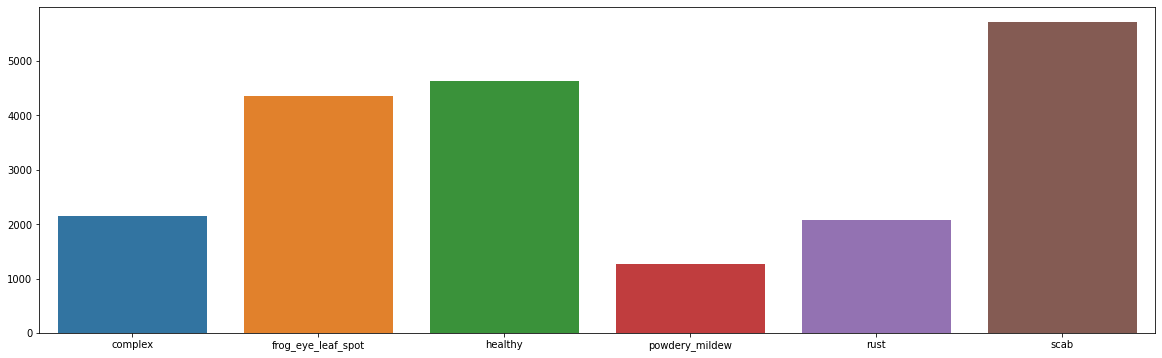

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

In [5]:
images = []

for img_name in tqdm(train['image']):
    path = './train_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((224,224))
        img.save(f'./train_images/{img_name}')
    img = cv2.imread(path)
    images.append(img)

100%|████████████████████████████████████| 18632/18632 [00:48<00:00, 381.22it/s]


In [6]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

# images = images.astype('float32') / 255.0
images.shape

(18632, 224, 224, 3)

### Viewing some images

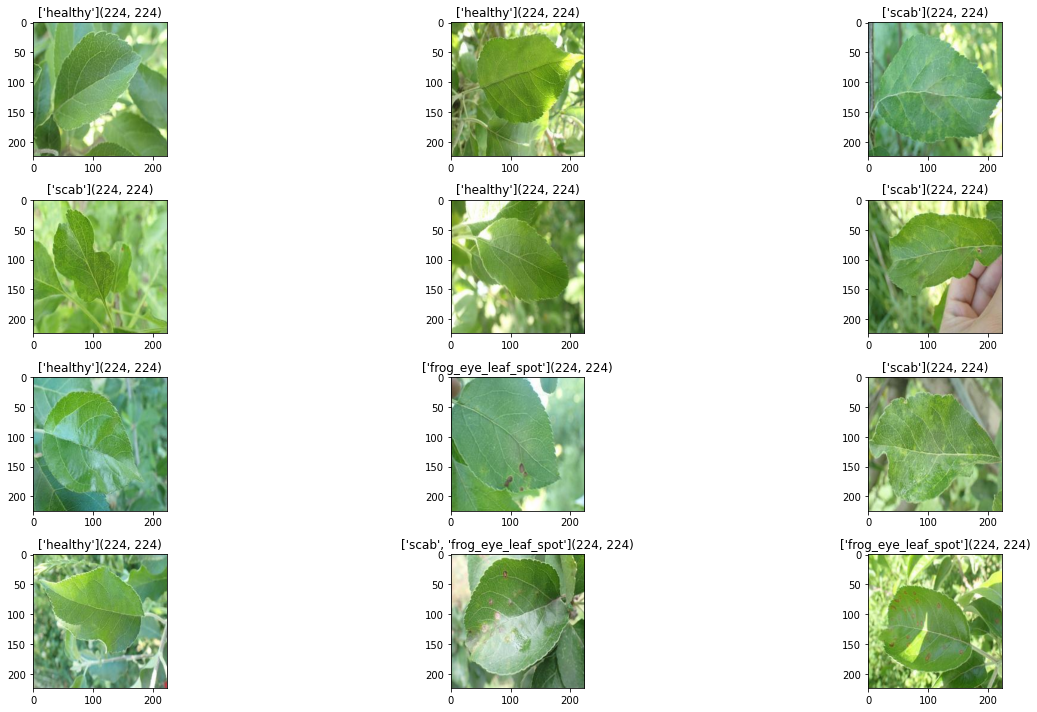

In [7]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

col_transformer = ColumnTransformer([
    ('multi-hot', MultiHotEncoder(), ['labels'])
])
Y = col_transformer.fit_transform(train)
print(col_transformer.named_transformers_['multi-hot'].categories_)
Y

[array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew',
       'rust', 'scab'], dtype=object)]


array([[0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]])

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

print(Y)

images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

[[0 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 ...
 [0 0 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 0]]
(14905, 224, 224, 3)
(14905, 6)
(3727, 224, 224, 3)
(3727, 6)


# Image Classification Using EfficientNet B0 with Transfer learning from pre-trained weights

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 6
IMG_SIZE = 224

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model



model = build_model(num_classes=NUM_CLASSES)

2022-03-24 06:42:57.627064: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 06:42:57.627130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-cpu): /proc/driver/nvidia/version does not exist
2022-03-24 06:42:57.628757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Epoch 1/60
466/466 - 316s - loss: 8.4311 - accuracy: 0.5087 - 316s/epoch - 678ms/step
Epoch 2/60
466/466 - 310s - loss: 25.0678 - accuracy: 0.4888 - 310s/epoch - 665ms/step
Epoch 3/60
466/466 - 315s - loss: 41.4367 - accuracy: 0.4839 - 315s/epoch - 675ms/step
Epoch 4/60
466/466 - 315s - loss: 57.5621 - accuracy: 0.4819 - 315s/epoch - 675ms/step
Epoch 5/60
466/466 - 314s - loss: 74.3355 - accuracy: 0.4604 - 314s/epoch - 673ms/step
Epoch 6/60
466/466 - 328s - loss: 81.0760 - accuracy: 0.4694 - 328s/epoch - 705ms/step
Epoch 7/60
466/466 - 314s - loss: 101.0289 - accuracy: 0.4633 - 314s/epoch - 673ms/step
Epoch 8/60
466/466 - 317s - loss: 107.6353 - accuracy: 0.4615 - 317s/epoch - 679ms/step
Epoch 9/60
466/466 - 309s - loss: 114.9967 - accuracy: 0.4644 - 309s/epoch - 663ms/step
Epoch 10/60
466/466 - 308s - loss: 144.4471 - accuracy: 0.4451 - 308s/epoch - 660ms/step
Epoch 11/60
466/466 - 311s - loss: 145.1203 - accuracy: 0.4562 - 311s/epoch - 668ms/step
Epoch 12/60
466/466 - 303s - loss: 16

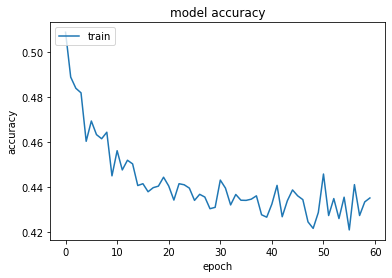

In [19]:
epochs = 60 
hist = model.fit(train_x, train_y, epochs=epochs, verbose=2)
plot_hist(hist)

In [20]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

117/117 [==============================] - 78s 646ms/step - loss: 183.8434 - accuracy: 0.6222
Loss = 183.84336853027344
Test Accuracy = 0.6222162842750549


# Testing Efficient Model On Unseen data

test_images/c7b03e718489f3ca.jpg
Input image shape: (1, 224, 224, 3)
predicted class:  [[0. 1. 0. 0. 0. 0.]]
test_images/85f8cb619c66b863.jpg
Input image shape: (1, 224, 224, 3)
predicted class:  [[0. 0. 0. 0. 1. 0.]]
test_images/ad8770db05586b59.jpg
Input image shape: (1, 224, 224, 3)
predicted class:  [[0. 1. 0. 0. 0. 0.]]


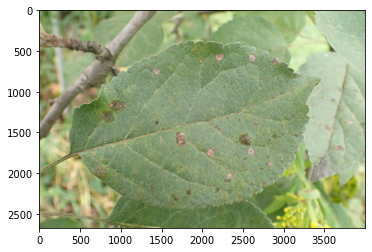

In [21]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


path = 'test_images/'
dataset_path = os.listdir('test_images')

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

for i in dataset_path:
    img_path = path + str(i)
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    print('Input image shape:', x.shape)

    my_image = imread(img_path)
    imshow(my_image)
    
    preds=model.predict(x)
    print("predicted class: ", preds )